In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-03-01 11:22:46,408: Default instance: ibm-q-iitmadras/internal/default


# Imports

In [2]:
!pip install qiskit_experiments

  Using cached qiskit_experiments-0.6.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached qiskit_ibm_experiment-0.4.7-py3-none-any.whl.metadata (6.2 kB)
  Using cached uncertainties-3.1.7-py2.py3-none-any.whl.metadata (14 kB)
  Using cached lmfit-1.2.2-py3-none-any.whl.metadata (9.9 kB)
  Using cached asteval-0.9.31-py3-none-any.whl.metadata (2.0 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
Using cached qiskit_experiments-0.6.0-py3-none-any.whl (733 kB)
Using cached qiskit_ibm_experiment-0.4.7-py3-none-any.whl (57 kB)
Using cached lmfit-1.2.2-py3-none-any.whl (102 kB)
Using cached uncertainties-3.1.7-py2.py3-none-any.whl (98 kB)
Using cached asteval-0.9.31-py3-none-any.whl (20 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)


In [3]:
!pip install jax

  Using cached jax-0.4.24-py3-none-any.whl (1.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)


In [4]:
!pip install jaxlib

  Using cached jaxlib-0.4.24-cp310-cp310-manylinux2014_x86_64.whl (80.8 MB)


In [3]:
from qiskit_experiments.library import Rabi, T2Hahn
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment

from qiskit import schedule, pulse
from qiskit.pulse.library import Constant
from qiskit.pulse.channels import DriveChannel, ControlChannel
from qiskit.circuit import Parameter
from qiskit.pulse.builder import seconds_to_samples
#from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit_ibm_provider import IBMProvider
#from qiskit.providers.fake_provider import FakeKolkata, FakeOpenPulse3Q
#from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend

from typing import List, Optional, Union, Sequence
import numpy as np

from qiskit import QuantumCircuit, QiskitError
from qiskit.circuit import Parameter
from qiskit.providers.backend import Backend

from qiskit_experiments.framework import BackendTiming, BaseExperiment, Options
from qiskit_experiments.library.characterization.analysis.t1_analysis import T1Analysis
from qiskit_experiments.library.characterization.analysis.t2hahn_analysis import T2HahnAnalysis
#from qiskit_experiments.warnings import qubit_deprecate

# import jax
# jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")
# from qiskit_dynamics.array import Array
# Array.set_default_backend("jax")
# from qiskit_dynamics import DynamicsBackend

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Choosing Provider

In [4]:
instance = 'ibm-q-iitmadras/internal/default'
#instance = 'ibm-q-iitmadras/internal/reservations'

provider = IBMProvider(instance = instance)

provider_algiers = provider.get_backend('ibm_algiers')
#provider_cairo = provider.get_backend('ibm_cairo')
#fake_kolkata = FakeKolkata()
#pulse_sim = FakeOpenPulse3Q()

# Defining Backend Timing Methods

In [5]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

In [6]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [7]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

# Defining Pulse Methods

In [8]:
def constant_pulse(backend, physical_qubits, drive_duration) : 
    
    Rabi_sched = []
    
    for qubit in range(len(physical_qubits)) :
        amp = Parameter('amp')
        drive_channel = DriveChannel(physical_qubits[qubit])
        
        with pulse.build(backend = backend, default_alignment='sequential', name = 'rabi-' + str(physical_qubits[qubit])) as Rabi_constant :
            pulse.set_frequency(qubit_freq[qubit], drive_channel)
            pulse.play(Constant(duration = get_closest_multiple_of_16(seconds_to_samples(drive_duration)),
                               amp = amp,
                               name = 'constant-' + str(physical_qubits[qubit])),
                      drive_channel)
        Rabi_sched.append(Rabi_constant)
    return Rabi_sched         

In [9]:
def Rabi_cal_parallel(physical_qubits, backend, schedules, amplitudes) :
    
    Rabi_exps = [Rabi(physical_qubits = [qubit],
                      backend = backend,
                      schedule = Rabi_sched[i],
                      amplitudes = amplitudes) for i, qubit in enumerate(physical_qubits)]
    
    # Set transpile options
    #transpile_options = {"basis_gates": provider_kolkata.configuration().basis_gates, "optimization_level": 1}
    #for rabi in Rabi_exps:
     #   rabi.set_transpile_options(**transpile_options)
       # rabi.set_experiment_options(trials=100)
    
    Rabi_parallel = ParallelExperiment(Rabi_exps, flatten_results = False)
    
    Rabi_parallel_data = Rabi_parallel.run(backend = backend).block_for_results()
    
    Rabi_result = [Rabi_parallel, Rabi_parallel_data]
    return Rabi_result

In [10]:
def x_pulse_sched(backend, physical_qubits, drive_duration) :
    Pi_cal_sched = []
    
    for qubit in range(len(physical_qubits)) :
        amp = float(str(Rabi_result[1].child_data()[qubit].analysis_results('@Parameters_OscillationAnalysis').value.ufloat_params['amp']).split('+')[0])
        drive_channel = DriveChannel(physical_qubits[qubit])
        
        with pulse.build(backend = backend, default_alignment='sequential', name = 'Pi-' + str(physical_qubits[qubit])) as Pi_cal :
            pulse.set_frequency(qubit_freq[qubit], drive_channel)
            pulse.play(Constant(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration)),
                               amp = amp,
                               name = 'Pi-' + str(physical_qubits[qubit])),
                      drive_channel)
        Pi_cal_sched.append(Pi_cal)
    return Pi_cal_sched

In [11]:
def sx_pulse_sched(backend, physical_qubits, drive_duration) :
    Pi_over_2_cal_sched = []
    
    for qubit in range(len(physical_qubits)) :
        amp = float(str(Rabi_result[1].child_data()[qubit].analysis_results('@Parameters_OscillationAnalysis').value.ufloat_params['amp']).split('+')[0])/2 #change later to Rabi_result[1].child_data()[qubit]
        drive_channel = DriveChannel(physical_qubits[qubit])
        
        with pulse.build(backend = backend, name = 'Pi_over_two-' + str(physical_qubits[qubit])) as Pi_over_2_cal :
            pulse.set_frequency(qubit_freq[qubit], drive_channel)
            with pulse.align_sequential() :
                pulse.play(Constant(duration = drive_duration,
                                   amp = amp,
                                   name = 'Pi_over_two-' + str(physical_qubits[qubit])),
                          drive_channel)
            Pi_over_2_cal_sched.append(Pi_over_2_cal)
    return Pi_over_2_cal_sched

In [12]:
def y_pulse_sched(backend, physical_qubits, drive_duration) :
    y_sched = []
    
    for qubit in range(len(physical_qubits)) :
        amp = float(str(Rabi_result[1].child_data()[qubit].analysis_results('@Parameters_OscillationAnalysis').value.ufloat_params['amp']).split('+')[0])
        drive_channel = DriveChannel(physical_qubits[qubit])
        control_channel = ControlChannel(physical_qubits[qubit])
        
        with pulse.build(backend = backend, default_alignment='sequential', name = 'y-' + str(physical_qubits[qubit])) as y_cal :
            pulse.shift_phase(np.pi, drive_channel)
            pulse.shift_phase(np.pi, control_channel)
            pulse.set_frequency(qubit_freq[qubit], drive_channel)
            pulse.play(Constant(duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration)),
                               amp = amp,
                               name = 'Pi-' + str(physical_qubits[qubit])),
                      drive_channel)
        y_sched.append(y_cal)
    return y_sched

# CPMG Pulse timings

In [13]:
# %%
# Create CPMG-like pulse timing array
def cpmgFilter(n, Tmax):
    tpi = np.empty([n])
    for i in range(n):
        tpi[i]= Tmax*(((i+1)-0.5)/n)
    return tpi

# Defining Experiment Classes : Hahn, X32, XY84, T1

In [14]:
class Calibrated_T1(BaseExperiment):
   
    @classmethod
    def _default_experiment_options(cls) -> Options:
        
        options = super()._default_experiment_options()
        options.delays = None
        options.x_pulse = None
        return options

    def __init__(
        self,
        physical_qubits: Sequence[int],
        delays: Union[List[float], np.array],
        x_pulse = None,
        backend: Optional[Backend] = None,
    ):
   
        # Initialize base experiment
        super().__init__(physical_qubits, analysis=T1Analysis(), backend=backend)

        # Set experiment options
        self.set_experiment_options(delays=delays, x_pulse=x_pulse)
        
    def circuits(self) -> List[QuantumCircuit]:
        
        x_pulse = self.experiment_options.x_pulse
        
        timing = BackendTiming(self.backend)

        circuits = []
        for delay in self.experiment_options.delays:
            circ = QuantumCircuit(1, 1)
            circ.x(0)
            circ.barrier(0)
            circ.delay(timing.round_delay(time=delay), 0, timing.delay_unit)
            circ.barrier(0)
            circ.measure(0, 0)
            
            circ.add_calibration('x', [0], x_pulse)
            
            circ.metadata = {"xval": timing.delay_time(time=delay)}

            circuits.append(circ)

        return circuits


    def _metadata(self):
        metadata = super()._metadata()
        # Store measurement level and meas return if they have been
        # set for the experiment
        for run_opt in ["meas_level", "meas_return"]:
            if hasattr(self.run_options, run_opt):
                metadata[run_opt] = getattr(self.run_options, run_opt)
        return metadata


In [15]:
class Calibrated_T2Hahn(BaseExperiment):
    
    def _default_experiment_options(cls) -> Options:
      
        options = super()._default_experiment_options()

        options.delays = None
        options.num_echoes = 1
        options.x_pulse = None
        return options

    def __init__(
        self,
        physical_qubits: Sequence[int],
        delays: Union[List[float], np.array],
        num_echoes: int = 1,
        x_pulse = None,
        backend: Optional[Backend] = None,
    ):
       
        # Initialize base experiment
        super().__init__(physical_qubits, analysis=T2HahnAnalysis(), backend=backend)

        # Set experiment options
        self.set_experiment_options(delays=delays, num_echoes=num_echoes, x_pulse=x_pulse)
        self._verify_parameters()

    def _verify_parameters(self):
        """
        Verify input correctness, raise QiskitError if needed.

        Raises:
            QiskitError : Error for invalid input.
        """
        if any(delay < 0 for delay in self.experiment_options.delays):
            raise QiskitError(
                f"The lengths list {self.experiment_options.delays} should only contain "
                "non-negative elements."
            )

            
    def circuits(self) -> List[QuantumCircuit]:

        timing = BackendTiming(self.backend)

        delay_param = Parameter("delay")

        num_echoes = self.experiment_options.num_echoes
        
        x_pulse = self.experiment_options.x_pulse

        # First X rotation in 90 degrees
        template = QuantumCircuit(1, 1)
        template.rx(np.pi / 2, 0)  # Brings the qubit to the X Axis
        if num_echoes == 0:
            # if number of echoes is 0 then just apply the delay gate
            template.delay(delay_param, 0, timing.delay_unit)
        else:
            for _ in range(num_echoes):
                template.delay(delay_param, 0, timing.delay_unit)
                template.x(0)
                template.delay(delay_param, 0, timing.delay_unit)

        if num_echoes % 2 == 1:
            template.rx(np.pi / 2, 0)  # X90 again since the num of echoes is odd
        else:
            template.rx(-np.pi / 2, 0)  # X(-90) again since the num of echoes is even
        template.measure(0, 0)  # measure
        
        template.add_calibration('x', [0], x_pulse)
        
        circuits = []
        for delay in self.experiment_options.delays:
            if num_echoes == 0:
                single_delay = timing.delay_time(time=delay)
                total_delay = single_delay
            else:
                # Equal delay is put before and after each echo, so each echo gets
                # two delay gates. When there are multiple echoes, the total delay
                # between echoes is 2 * single_delay, made up of two delay gates.
                single_delay = timing.delay_time(time=delay / num_echoes / 2)
                total_delay = single_delay * num_echoes * 2

            assigned = template.assign_parameters(
                {delay_param: timing.round_delay(time=single_delay)}, inplace=False
            )
            assigned.metadata = {"xval": total_delay}
            circuits.append(assigned)

        return circuits


    def _metadata(self):
        metadata = super()._metadata()
        # Store measurement level and meas return if they have been
        # set for the experiment
        for run_opt in ["meas_level", "meas_return"]:
            if hasattr(self.run_options, run_opt):
                metadata[run_opt] = getattr(self.run_options, run_opt)
        return metadata

In [16]:
class Calibrated_XY(BaseExperiment):
    
    def _default_experiment_options(cls) -> Options:
      
        options = super()._default_experiment_options()

        options.delays = None
        options.num_echoes = 1
        options.x_pulse = None
        options.y_pulse = None
        options.sequence_length = 1
        return options

    def __init__(
        self,
        physical_qubits: Sequence[int],
        delays: Union[List[float], np.array],
        num_echoes: int = 1,
        x_pulse = None,
        y_pulse = None,
        sequence_length: int = 1,
        backend: Optional[Backend] = None,
    ):
       
        # Initialize base experiment
        super().__init__(physical_qubits, analysis=T2HahnAnalysis(), backend=backend)

        # Set experiment options
        self.set_experiment_options(delays=delays, num_echoes=num_echoes, x_pulse=x_pulse, y_pulse=y_pulse, sequence_length=sequence_length)
        self._verify_parameters()

    def _verify_parameters(self):
        """
        Verify input correctness, raise QiskitError if needed.

        Raises:
            QiskitError : Error for invalid input.
        """
        if any(delay < 0 for delay in self.experiment_options.delays):
            raise QiskitError(
                f"The lengths list {self.experiment_options.delays} should only contain "
                "non-negative elements."
            )
            
        if self.experiment_options.sequence_length < 0:
            raise QiskitError(
                f"The sequence length {self.experiment_options.sequence_length} should only contain "
                "non-negative elements."
            )    
        

            
    def circuits(self) -> List[QuantumCircuit]:

        timing = BackendTiming(self.backend)

        delay_param = Parameter("delay")

        num_echoes = self.experiment_options.num_echoes
        
        x_pulse = self.experiment_options.x_pulse
        y_pulse = self.experiment_options.y_pulse
        
        sequence_length = self.experiment_options.sequence_length
        num_sequences = int(num_echoes / sequence_length)

        # First X rotation in 90 degrees
        template = QuantumCircuit(1, 1)
        template.rx(np.pi / 2, 0)  # Brings the qubit to the X Axis
        if num_echoes == 0 :
            # if number of echoes is 0 then just apply the delay gate
            template.delay(delay_param, 0, timing.delay_unit)
        else :
            
            for j in range(num_sequences) :
                
                i = 0
                k = 0
                
                while i < sequence_length :
                    
                    if k < int(sequence_length / 2) :
                    
                        k = k + 1

                        template.delay(delay_param, 0, timing.delay_unit)
                        template.x(0)
                        template.delay(delay_param, 0, timing.delay_unit)
                        
                        i = i + 1

                        if i < sequence_length :
                            
                            k = k + 1
                            
                            template.delay(delay_param, 0, timing.delay_unit)
                            template.y(0)
                            template.delay(delay_param, 0, timing.delay_unit)
                            
                            i = i + 1
                            
                            
                        else : 
                            
                            pass
                        

                    elif int(sequence_length / 2) <= k and k < sequence_length :

                        k = k + 1

                        template.delay(delay_param, 0, timing.delay_unit)
                        template.y(0)
                        template.delay(delay_param, 0, timing.delay_unit)

                        i = i + 1

                        if i < sequence_length :

                            k = k + 1

                            template.delay(delay_param, 0, timing.delay_unit)
                            template.x(0)
                            template.delay(delay_param, 0, timing.delay_unit)

                            i = i + 1
                            
                        else :
                            
                            pass
                                
                
        if num_echoes % 2 == 1 :
            template.rx(np.pi / 2, 0)  # X90 again since the num of echoes is odd
        else:
            template.rx(-np.pi / 2, 0)  # X(-90) again since the num of echoes is even
        template.measure(0, 0)  # measure
        
        template.add_calibration('x', [0], x_pulse)
        template.add_calibration('y', [0], y_pulse)
        
        circuits = []
        for delay in self.experiment_options.delays:
            if num_echoes == 0:
                single_delay = timing.delay_time(time=delay)
                total_delay = single_delay
            else:
                # Equal delay is put before and after each echo, so each echo gets
                # two delay gates. When there are multiple echoes, the total delay
                # between echoes is 2 * single_delay, made up of two delay gates.
                single_delay = timing.delay_time(time=delay / num_echoes / 2)
                total_delay = single_delay * num_echoes * 2

            assigned = template.assign_parameters(
                {delay_param: timing.round_delay(time=single_delay)}, inplace=False
            )
            assigned.metadata = {"xval": total_delay}
            circuits.append(assigned)

        return circuits


    def _metadata(self):
        metadata = super()._metadata()
        # Store measurement level and meas return if they have been
        # set for the experiment
        for run_opt in ["meas_level", "meas_return"]:
            if hasattr(self.run_options, run_opt):
                metadata[run_opt] = getattr(self.run_options, run_opt)
        return metadata

# Defining Batch Experiment : T1 + T2

In [17]:
def Calibrated_batch_all (delays, num_echoes_hahn, num_echoes_multiplier, sequence_length, shots, backend, physical_qubits, num_batches, x_pulse_sched, y_pulse_sched) :
    
    t2_XY = []
    t2_X = []
    t2_hahn = []
    t1 = []
    
    for i, qubit in enumerate(physical_qubits) :
        
        x_pulse = x_pulse_sched[i]
        y_pulse = y_pulse_sched[i]
    
        exp_XY = Calibrated_XY(physical_qubits = [qubit],
                               delays = delays,
                               num_echoes = num_echoes_multiplier,
                               x_pulse = x_pulse,
                               y_pulse = y_pulse,
                               sequence_length = sequence_length,
                               backend = backend)
        
        exp_X = Calibrated_T2Hahn(physical_qubits = [qubit],
                                  delays = delays,
                                  num_echoes = num_echoes_multiplier,
                                  x_pulse = x_pulse,
                                  backend = backend)
        
        exp_hahn = Calibrated_T2Hahn(physical_qubits = [qubit],
                                     delays = delays,
                                     num_echoes = num_echoes_hahn,
                                     x_pulse = x_pulse,
                                     backend = backend)
        
        exp_t1 = Calibrated_T1(physical_qubits = [qubit],
                               delays = delays,
                               x_pulse = x_pulse,
                               backend = backend)
        
        exp_XY.set_run_options(shots = shots)
        exp_X.set_run_options(shots = shots)
        exp_hahn.set_run_options(shots = shots)
        exp_t1.set_run_options(shots = shots)
        
        t2_XY.append(exp_XY)
        t2_X.append(exp_X)
        t2_hahn.append(exp_hahn)
        t1.append(exp_t1)
    
    exp_cal = []
    
    for j in range(num_batches) :
        
        for i in range(len(physical_qubits)) :
            
            exp_cal.append(t1[i])
            exp_cal.append(t2_hahn[i])
            exp_cal.append(t2_X[i])
            exp_cal.append(t2_XY[i])
        
    ########
    
    batch_exp = BatchExperiment(exp_cal, 
                                backend = backend, 
                                flatten_results = False)
    
    batch_exp.set_run_options(shots = shots)
    
    batch_result = batch_exp.run(backend = backend).block_for_results()
    
    return batch_exp, batch_result

In [23]:
def Calibrated_time_dep_batch_T1_X32 (delays, num_echoes_multiplier, shots, backend, physical_qubits, num_batches, x_pulse_sched) :
    
    t2_X = []
    t1 = []
    
    for i, qubit in enumerate(physical_qubits) :
        
        x_pulse = x_pulse_sched[i]
        
        exp_X = Calibrated_T2Hahn(physical_qubits = [qubit],
                                  delays = delays,
                                  num_echoes = num_echoes_multiplier,
                                  x_pulse = x_pulse,
                                  backend = backend)
        
        exp_t1 = Calibrated_T1(physical_qubits = [qubit],
                               delays = delays,
                               x_pulse = x_pulse,
                               backend = backend)
        
        exp_X.set_run_options(shots = shots)
        exp_t1.set_run_options(shots = shots)
        
        t2_X.append(exp_X)
        t1.append(exp_t1)
    
    exp_cal = []
    
    for j in range(len(physical_qubits)) :
        
        for i in range(num_batches) :
            
            exp_cal.append(t1[j])
            exp_cal.append(t2_X[j])
        
    ########
    
    batch_exp = BatchExperiment(exp_cal, 
                                backend = backend, 
                                flatten_results = False)
    
    batch_exp.set_run_options(shots = shots)
    
    batch_result = batch_exp.run(backend = backend).block_for_results()
    
    return batch_exp, batch_result

# Set Global Parameters

In [18]:
#backend = provider_cairo
backend = provider_algiers
#backend = fake_kolkata

shots = 4000
max_evolution = 4 * 180e-6
min_evolution = 2e-6
num_samples = 150
num_batches = 5
num_echoes_hahn = 1
num_echoes_multiplier = 32
sequence_length = 16

config_backend = backend.configuration()

props_backend = backend.properties()

#physical_qubits = [6, 10, 13, 15, 20, 21, 22] # the no crosstalk qubits selected from previous experiment   

# physical_qubits = []
# for i in range(config_backend.n_qubits) :
#     if 60e-6 < props_backend.t2(i) and props_backend.t2(i) < 180e-6 :
#         physical_qubits.append(i)

physical_qubits = [15, 24]
        
print(physical_qubits)
        
T1_value = [props_backend.t1(i) for i in physical_qubits]
T2_value = [props_backend.t2(i) for i in physical_qubits]

print(T1_value)
print(T2_value)

[15, 24]
[9.282296773494456e-05, 0.00016957431060639783]
[0.00011068774988376109, 5.615124954715038e-05]


In [19]:
with pulse.build(backend) as u3_sched:
    seconds = 14e-9
    dt = backend.dt
    print('There are {} seconds in {} samples.'.format(seconds, pulse.seconds_to_samples(seconds)))
    print('1 over sampling rate is {} seconds.'.format(dt))
    print(config_backend.timing_constraints)

There are 1.4e-08 seconds in 63 samples.
1 over sampling rate is 2.2222222222222221e-10 seconds.
{'acquire_alignment': 16, 'granularity': 16, 'min_length': 64, 'pulse_alignment': 16}


In [20]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [21]:
drive_duration = 48e-9 # multiple of 16 !
amplitudes = np.linspace(-1, 1, 100)

qubit_freq = []

for qubit in physical_qubits :
    freq = props_backend.frequency(qubit)
    qubit_freq.append(freq) 
    
print(qubit_freq)    

[4807055508.216566, 5023834886.17473]


# Calculating Delays

In [23]:
# timings32_min = cpmgFilter(num_echoes_multiplier, min_evolution)
# timings32_max = cpmgFilter(num_echoes_multiplier, max_evolution)
# timings_hahn_min = cpmgFilter(num_echoes_hahn, min_evolution)
# timings_hahn_max = cpmgFilter(num_echoes_hahn, max_evolution)

In [24]:
# with pulse.build(backend) as tmin :
    
#     delay_min_32 = get_closest_multiple_of_16(seconds_to_samples(timings32_min[1] - timings32_min[0] - drive_duration))
#     delay_max_32 = get_closest_multiple_of_16(seconds_to_samples(timings32_max[1] - timings32_max[0] - drive_duration))
#     delay_min_hahn = get_closest_multiple_of_16(seconds_to_samples(min_evolution - timings_hahn_min[0] - drive_duration))
#     delay_max_hahn = get_closest_multiple_of_16(seconds_to_samples(max_evolution - timings_hahn_max[0] - drive_duration))

In [22]:
delays = np.geomspace(min_evolution, max_evolution, num_samples)

In [22]:
delays

array([2.00000000e-06, 2.08058943e-06, 2.16442619e-06, 2.25164113e-06,
       2.34237037e-06, 2.43675552e-06, 2.53494389e-06, 2.63708874e-06,
       2.74334948e-06, 2.85389197e-06, 2.96888874e-06, 3.08851926e-06,
       3.21297027e-06, 3.34243600e-06, 3.47711851e-06, 3.61722801e-06,
       3.76298318e-06, 3.91461152e-06, 4.07234968e-06, 4.23644386e-06,
       4.40715016e-06, 4.58473503e-06, 4.76947562e-06, 4.96166029e-06,
       5.16158898e-06, 5.36957374e-06, 5.58593919e-06, 5.81102303e-06,
       6.04517655e-06, 6.28876522e-06, 6.54216923e-06, 6.80578409e-06,
       7.08002122e-06, 7.36530867e-06, 7.66209169e-06, 7.97083350e-06,
       8.29201597e-06, 8.62614040e-06, 8.97372828e-06, 9.33532212e-06,
       9.71148627e-06, 1.01028079e-05, 1.05098976e-05, 1.09333910e-05,
       1.13739489e-05, 1.18322589e-05, 1.23090364e-05, 1.28050255e-05,
       1.33210004e-05, 1.38577663e-05, 1.44161611e-05, 1.49970562e-05,
       1.56013583e-05, 1.62300106e-05, 1.68839943e-05, 1.75643301e-05,
      

In [28]:
# DynamicsBackend Simulation

# dim = 3

# v0 = 4.86e9
# anharm0 = -0.32e9
# r0 = 0.22e9

# v1 = 4.97e9
# anharm1 = -0.32e9
# r1 = 0.26e9

# J = 0.002e9

# a = np.diag(np.sqrt(np.arange(1, dim)), 1)
# adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
# N = np.diag(np.arange(dim))

# ident = np.eye(dim, dtype=complex)
# full_ident = np.eye(dim**2, dtype=complex)

# N0 = np.kron(ident, N)
# N1 = np.kron(N, ident)

# a0 = np.kron(ident, a)
# a1 = np.kron(a, ident)

# a0dag = np.kron(ident, adag)
# a1dag = np.kron(adag, ident)


# static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
# static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

# static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

# drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
# drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# from qiskit_dynamics import Solver

# # build solver
# dt = 2/9e9

# solver = Solver(
#     static_hamiltonian=static_ham_full,
#     hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
#     rotating_frame=static_ham_full,
#     hamiltonian_channels=["d0", "d1", "u0", "u1"],
#     channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
#     dt=dt,
# )
# solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

# backend = DynamicsBackend(
#     solver=solver,
#     subsystem_dims=[dim, dim], # for computing measurement data
#     solver_options=solver_options, # to be used every time run is called
# )
#backend = DynamicsBackend.from_backend(provider_algiers)

#backend = SingleTransmonTestBackend(5.2e9,-.25e9, 1e9, 0.8e9, noise=True, seed=100)

# backend = pulse_sim
# qubit = [0, ]

# Performing Rabi

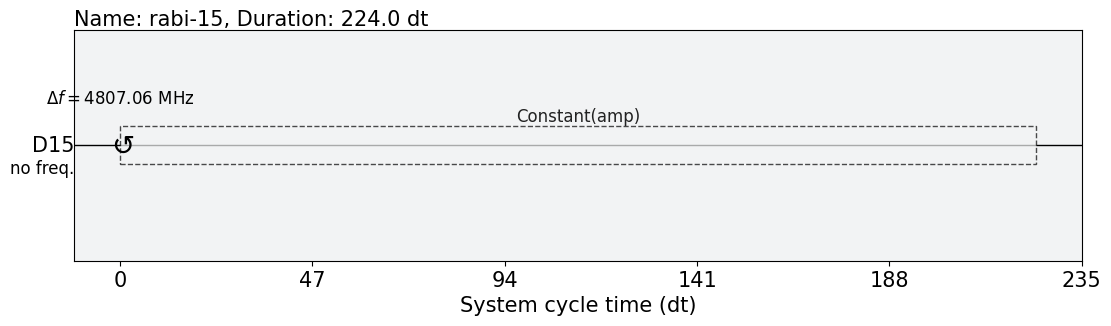

In [24]:
Rabi_sched = constant_pulse(backend = backend,
                            physical_qubits = physical_qubits,
                            drive_duration = drive_duration)

Rabi_sched[0].draw()

In [25]:
Rabi_result = Rabi_cal_parallel(physical_qubits = physical_qubits,
                                backend = backend,
                                schedules = Rabi_sched,
                                amplitudes = amplitudes)

/opt/conda/lib/python3.10/site-packages/qiskit_experiments/framework/composite/composite_experiment.py:171: UserWarning: Component 0 Rabi experiment run options ['meas_level', 'meas_return'] values [<MeasLevel.KERNELED: 1>, 'single'] will be overridden with ParallelExperiment values [<MeasLevel.CLASSIFIED: 2>, None].
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/qiskit_experiments/framework/composite/composite_experiment.py:171: UserWarning: Component 1 Rabi experiment run options ['meas_level', 'meas_return'] values [<MeasLevel.KERNELED: 1>, 'single'] will be overridden with ParallelExperiment values [<MeasLevel.CLASSIFIED: 2>, None].
  warnings.warn(


In [26]:
Rabi_fig_parallel = []

for i, sub_data in enumerate(Rabi_result[1].child_data()):
    Rabi_fig_parallel.append(sub_data.figure(0))

Component experiment 0


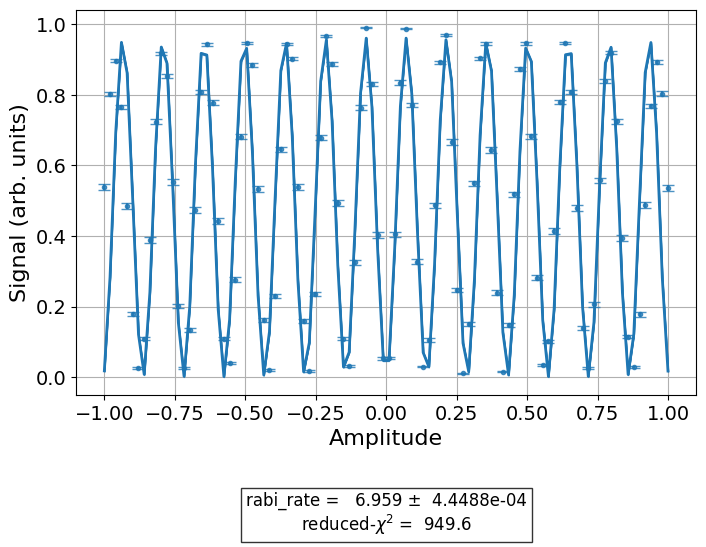

Component experiment 1


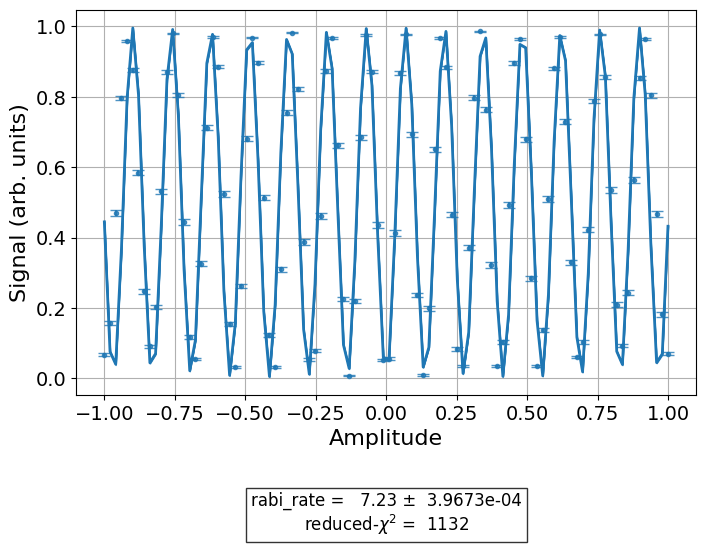

In [27]:
for i in range(len(physical_qubits)) :
    print("Component experiment",i)
    display(Rabi_fig_parallel[i])

# Calibrating Pulses

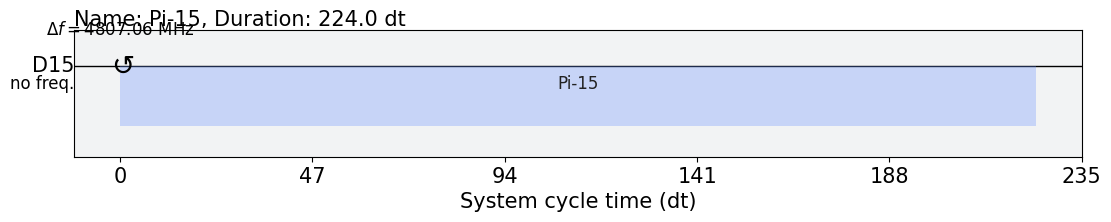

In [28]:
x_pulse_sched = x_pulse_sched(backend = backend,
                      physical_qubits = physical_qubits,
                      drive_duration = drive_duration)

x_pulse_sched[0].draw()

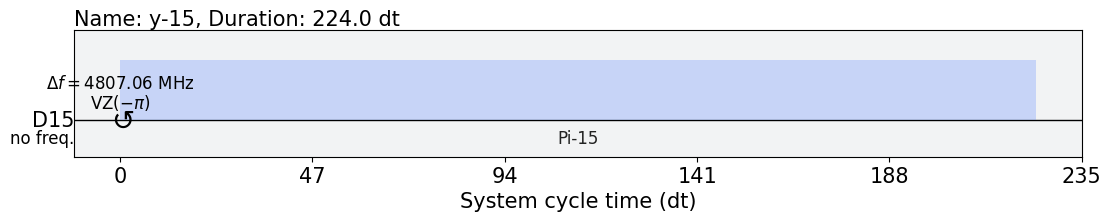

In [29]:
y_pulse_sched = y_pulse_sched(backend = backend,
                      physical_qubits = physical_qubits,
                      drive_duration = drive_duration)

y_pulse_sched[0].draw()

# Rabi Amplitudes

In [30]:
amplitudes = []
for qubit in range(len(physical_qubits)) :
    amp = float(str(Rabi_result[1].child_data()[qubit].analysis_results('@Parameters_OscillationAnalysis').value.ufloat_params['amp']).split('+')[0])
    amplitudes.append(amp)
    
print(amplitudes)

[-0.4797, 0.4951]


# Performing Calibrated Batch Experiment

In [ ]:
# batch_exps, batch_result = Calibrated_batch(delays = delays,
#                                             num_echoes_hahn = num_echoes_hahn,
#                                             num_echoes_multiplier = num_echoes_multiplier, 
#                                             sequence_length = sequence_length,
#                                             shots = shots, 
#                                             backend = backend, 
#                                             physical_qubits = physical_qubits, 
#                                             num_batches = num_batches,
#                                             x_pulse_sched = x_pulse_sched,
#                                             y_pulse_sched = y_pulse_sched)

batch_exps, batch_result = Calibrated_time_dep_batch_T1_X32 (delays = delays, 
                                                  num_echoes_multiplier = num_echoes_multiplier, 
                                                  shots = shots, 
                                                  backend = backend, 
                                                  physical_qubits = physical_qubits, 
                                                  num_batches = num_batches, 
                                                  x_pulse_sched = x_pulse_sched)
                            


/opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_backend.py:447: UserWarning: The backend ibm_algiers is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


In [ ]:
# for i in range(num_batches * len(physical_qubits) * 4) :
#     if i%4 == 0 :
#         print('Physical_Qubit ' + str(physical_qubits[int(i/(4*num_batches))]))
#     display(batch_result.child_data()[i].figure(0))
    
for i in range(num_batches * len(physical_qubits) * 2) :
    if i%4 == 0 :
        print('Physical_Qubit ' + str(physical_qubits[int(i/(2*num_batches))]))
    display(batch_result.child_data()[i].figure(0))    
